In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/LAB_mod_B/Project

/content/drive/MyDrive/Colab Notebooks/LAB_mod_B/Project


In [ ]:
import sys
print(sys.executable)

/usr/bin/python3


# Importazione librerie

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyarrow

**INFO SUI DATI**:
- la frequenza temporale è oraria
- il volume di sbilanciamento è l'energia espressa in MWh - sulla base della quale si possono definire delle classi o avere un target di regressione più sensato

# Importazione dati

In [ ]:
# i files sbil_SUD - sbil_NORD vanno spostati dentro la cartella lcpb_files
df_sbil = pd.DataFrame()

for zone in ['NORD', 'SUD']:
  filename = f"lcpb_files/sbil_{zone}"
  df_sbil_temp = pd.read_parquet(filename)
  df_sbil_temp['zone'] = zone
  df_sbil = pd.concat([df_sbil, df_sbil_temp])

df_sbil.sample(10)

,date_time,price,volume,sign,zone
24453,2024-10-15 20:00:00,162.604,-11.020,-1.0,NORD
13879,2023-08-02 07:00:00,192.056,-290.580,-1.0,NORD
3067,2022-05-08 19:00:00,196.804,228.704,1.0,SUD
25524,2024-11-29 11:00:00,103.113,540.894,1.0,NORD
9090,2023-01-14 18:00:00,291.119,-1012.092,-1.0,NORD
6647,2022-10-04 23:00:00,446.826,-143.605,-1.0,NORD
21016,2024-05-25 15:00:00,223.367,-69.113,-1.0,SUD
7216,2022-10-28 16:00:00,249.274,-31.908,-1.0,SUD
945,2022-02-09 09:00:00,NaN,78.573,1.0,SUD
2838,2022-04-29 06:00:00,189.023,264.989,1.0,NORD


## Aggregazione dati ogni 3 ore

In [ ]:
df_sbil = df_sbil.set_index('date_time')

df_sbil = df_sbil.groupby('zone').resample('3h').sum()['volume']     # gruppi di 3 ore
df_sbil = df_sbil.reset_index()

df_sbil

,zone,date_time,volume
0,NORD,2022-01-01 00:00:00,-1787.609
1,NORD,2022-01-01 03:00:00,-1186.383
2,NORD,2022-01-01 06:00:00,-3447.250
3,NORD,2022-01-01 09:00:00,-2296.011
4,NORD,2022-01-01 12:00:00,-3370.281
...,...,...,...
17531,SUD,2024-12-31 09:00:00,704.432
17532,SUD,2024-12-31 12:00:00,700.109
17533,SUD,2024-12-31 15:00:00,181.575
17534,SUD,2024-12-31 18:00:00,3078.037


In [ ]:
df_sbil['date'] = df_sbil['date_time'].dt.date
df_sbil['time'] = df_sbil['date_time'].dt.time
df_sbil['year'] = df_sbil['date_time'].dt.year
df_sbil['month'] = df_sbil['date_time'].dt.month

df_sbil

,zone,date_time,volume,date,time,year,month
0,NORD,2022-01-01 00:00:00,-1787.609,2022-01-01,00:00:00,2022,1
1,NORD,2022-01-01 03:00:00,-1186.383,2022-01-01,03:00:00,2022,1
2,NORD,2022-01-01 06:00:00,-3447.250,2022-01-01,06:00:00,2022,1
3,NORD,2022-01-01 09:00:00,-2296.011,2022-01-01,09:00:00,2022,1
4,NORD,2022-01-01 12:00:00,-3370.281,2022-01-01,12:00:00,2022,1
...,...,...,...,...,...,...,...
17531,SUD,2024-12-31 09:00:00,704.432,2024-12-31,09:00:00,2024,12
17532,SUD,2024-12-31 12:00:00,700.109,2024-12-31,12:00:00,2024,12
17533,SUD,2024-12-31 15:00:00,181.575,2024-12-31,15:00:00,2024,12
17534,SUD,2024-12-31 18:00:00,3078.037,2024-12-31,18:00:00,2024,12


# Primo plot 2022 - 2025 Nord vs Sud

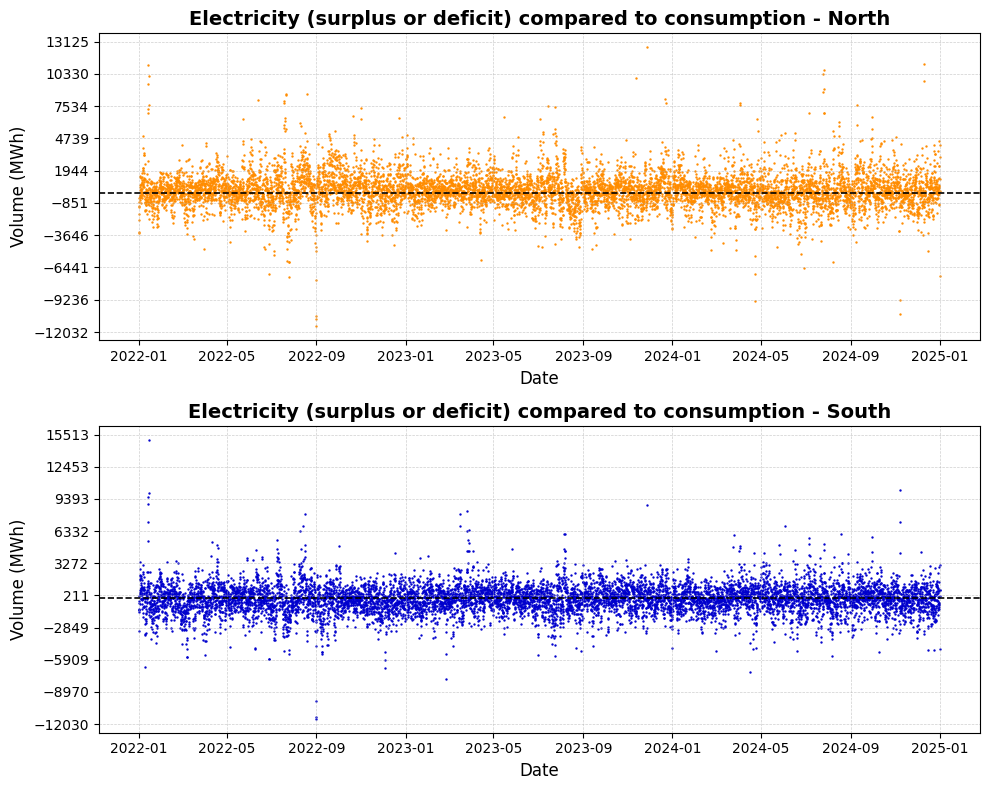

In [ ]:
fig, ax = plt.subplots(nrows=2, figsize=[10, 8])

y_values_nord = df_sbil[df_sbil['zone'] == 'NORD']['volume']
y_values_sud = df_sbil[df_sbil['zone'] == 'SUD']['volume']

ax[0].scatter(df_sbil[df_sbil['zone'] == 'NORD']['date_time'], y_values_nord, s = 0.5, label='North', color='darkorange')
ax[0].set_xlabel("Date", fontsize = 12)
ax[0].set_ylabel("Volume (MWh)", fontsize = 12)
ax[0].axhline(0, color='black', linestyle='--', linewidth=1.2)
ax[0].set_title("Electricity (surplus or deficit) compared to consumption - North", fontsize = 14, fontweight = 'bold')
ax[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
ax[0].set_yticks(np.linspace(y_values_nord.min() - 500, y_values_nord.max() + 500, 10))

ax[1].scatter(df_sbil[df_sbil['zone'] == 'SUD']['date_time'], y_values_sud, s = 0.5, label='SUD', color='mediumblue')
ax[1].set_xlabel("Date", fontsize = 12)
ax[1].set_ylabel("Volume (MWh)", fontsize = 12)
ax[1].axhline(0, color='black', linestyle='--', linewidth=1.2)
ax[1].set_title("Electricity (surplus or deficit) compared to consumption - South", fontsize = 14, fontweight = 'bold')
ax[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.6)
ax[1].set_yticks(np.linspace(y_values_sud.min() - 500, y_values_sud.max() + 500, 10))

plt.tight_layout()
plt.show()